In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib as mpl

In [2]:
uk_house_data_all = pd.read_csv(
    'datasets/uk_house_market_data.csv',
    names=[
        'Transaction_unique_identifier',
        'price',
        'date_of_sale',
        'postcode',
        'property_type',
        'old_new',
        'duration',
        'PAON',
        'SAON',
        'street',
        'locality',
        'town_city',
        'district',
        'county',
        'ppd_category_type',
        'record_status',
    ],
    dtype={'price': 'int64'}
)


In [3]:
sales_data_20_years = uk_house_data_all.query('date_of_sale >= "2000-01-01 00:00"')

In [4]:
yearly_data_since_2015 = {}

for year in range(2015, 2024):
    name = f"sales_data_{year}"
    values = sales_data_20_years[sales_data_20_years['date_of_sale'].str.startswith(f'{str(year)}')]
    yearly_data_since_2015[name] = values

In [5]:
yearly_properties_sold = {
    int(key[-4:]) : value['date_of_sale'].count()
    for key, value in yearly_data_since_2015.items()
}

<BarContainer object of 9 artists>

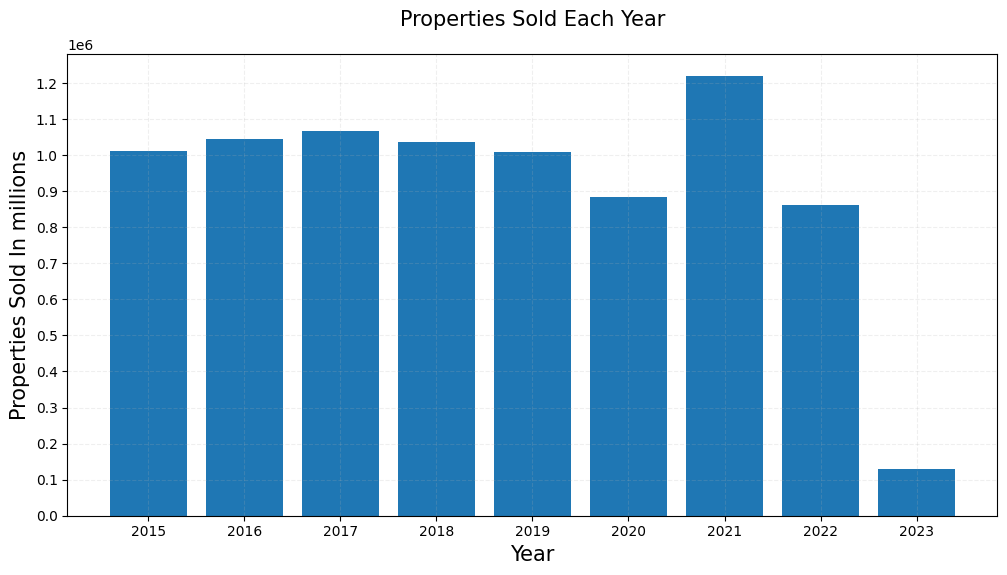

In [7]:
from matplotlib.pyplot import MultipleLocator

fig, ax = plt.subplots(figsize=(12, 6))
ax.grid(True, alpha=0.2, ls='dashed')
ax.set_title('Properties Sold Each Year', fontsize=15, pad=20)
plt.ylabel('Properties Sold In millions', fontsize=15)
plt.xlabel('Year', fontsize=15)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(100_000))

ax.bar(
    yearly_properties_sold.keys(), yearly_properties_sold.values()
)


C:\Users\danie\AppData\Local\Temp\ipykernel_8060\3422966821.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_2015['date_of_sale'] = pd.to_datetime(data_for_2015['date_of_sale'])


AttributeError: 'numpy.datetime64' object has no attribute 'month'

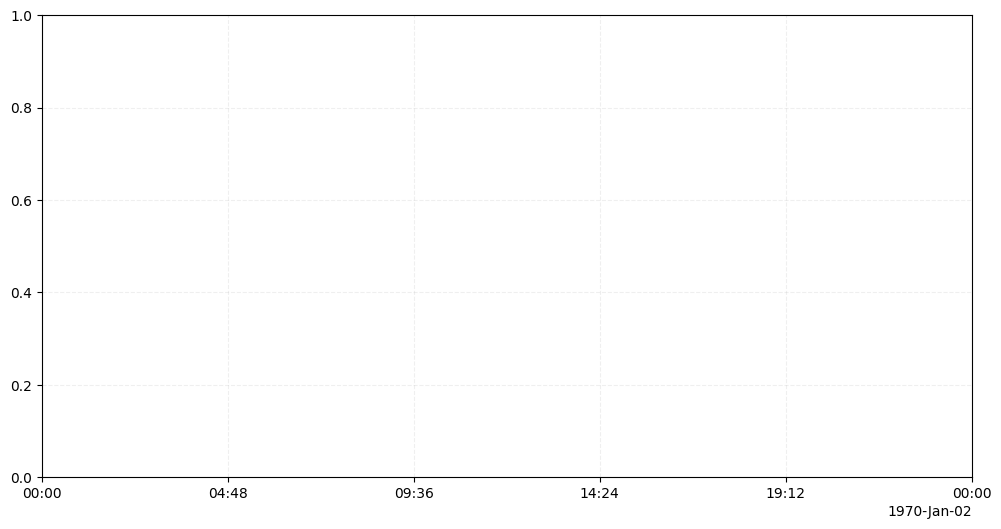

In [19]:
data_for_2015 = yearly_data_since_2015['sales_data_2015']
data_for_2015['date_of_sale'] = pd.to_datetime(data_for_2015['date_of_sale'])


fig, ax = plt.subplots(figsize=(12, 6))
ax.grid(True, alpha=0.2, ls='dashed')

cdf = mpl.dates.ConciseDateFormatter(ax.xaxis.get_major_locator())
ax.xaxis.set_major_formatter(cdf)

ax.plot(data_for_2015[''])

